In [25]:
import pickle as pkl
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from itertools import product
import rescomp as rc

In [3]:
def get_timestamp(filen):
    filen = filen.replace('_','').replace('-','')
    return filen[-16:-4]

#Load the data
results = []
#Change this to wherever you have the data
PATH = "../Data/results/all_results/"
for filen in glob(PATH + "**/*.pkl",recursive=True):
    #Ignore the config files
    if filen[-10:]!='config.pkl':
        with open(filen, 'rb') as file:
            item = pkl.load(file)
            item['filename'] = filen
            item['timestamp'] = get_timestamp(filen)
            results.append(item)

#Sort by timestamp, break ties alphabetically by experiment name
results.sort(key=lambda item:(item['timestamp']+' '.join(item['experiment'])))
for i in range(len(results)):
    results[i]['id']=i

In [105]:
print(len(results))
results[38]
#print([item['timestamp'] for item in results])

67


{'continue': [1.800012917396998,
  0.32000229642608247,
  1.5800113386039811,
  1.0000071763316782,
  2.560018371408887,
  1.000007176331792,
  1.490010692734188,
  0.8000057410652062,
  1.0400074633849954,
  2.1300152855865235,
  0.32000229642608247,
  1.890013563266848,
  0.2900020811362083,
  0.2700019376095497,
  1.6200116256572983,
  0.2700019376095497,
  1.4900106927341312,
  0.42000301405937535,
  0.8600061716451819,
  0.4900035164023393,
  0.4500032293492495,
  2.4400175102493336,
  0.22000157879290327,
  1.1600083245446058,
  0.6500046646156079],
 'random': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'cont_deriv_fit': [],
 'rand_deriv_fit': [],
 'lyapunov': [-0.015972740193868483,
  -0.02414397082295826,
  -0.017418377137849033,
  -0.02128739579125419,
  -0.022186073176888966,
  -0.01522845556255622,
  -0.010315684522418099,
  -0.01326136508736116

In [6]:
#Split the data by system

results_split = {item:[] for item in {'lorenz', 'thomas', 'rossler', 'softrobot'}}

#Exclude specific experiments
exclude_ids = {4,18,19,21,22,23,26,27,33,34,43,52,53,54}
for item in results:
    if item['id'] not in exclude_ids:
        results_split[item['experiment'][0]].append(item)

for name in results_split:
    print(f"{name}: {len(results_split[name])} items")

softrobot: 12 items
lorenz: 13 items
thomas: 15 items
rossler: 13 items


In [7]:
print([item['id'] for item in results_split['rossler']])

[44, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]


In [8]:
for id in exclude_ids:
    print(id, results[id]['experiment'])

33 ('rossler', 'activ_f', 'random', 'augmented')
34 ('rossler', 'random', 'random', 'augmented')
4 ('rossler', 'activ_f', 'continue', 'augmented')
43 ('rossler', 'relax', 'continue', 'augmented')
18 ('rossler', 'random', 'continue', 'augmented')
19 ('rossler', 'random', 'continue', 'standard')
52 ('rossler', 'activ_f', 'continue', 'augmented')
21 ('rossler', 'random', 'random', 'standard')
22 ('rossler', 'relax', 'continue', 'standard')
23 ('rossler', 'relax', 'random', 'standard')
53 ('rossler', 'activ_f', 'continue', 'standard')
54 ('rossler', 'random', 'continue', 'augmented')
26 ('rossler', 'activ_f', 'continue', 'standard')
27 ('rossler', 'activ_f', 'random', 'standard')


In [9]:
#Determine which experiments are missing
SYSTEM = ["lorenz", "rossler", "thomas", "softrobot"]
MAP_INITIAL = ["random", "activ_f", "relax"]
PREDICTION_TYPE = ["continue", "random"]
METHOD = ["standard", "augmented"]
all_exps = {item for item in product(SYSTEM, MAP_INITIAL, PREDICTION_TYPE, METHOD)}
ran_exps = {item['experiment'] for item in results if item['id'] not in exclude_ids}
missing = all_exps.difference(ran_exps)
if len(missing)==0:
    print("No experiments missing.")
else:
    print("Missing experiments:")
    for item in missing:
        print(item)

No experiments missing.


# Analysis - boxplots

In [19]:
def boxplots(data_list, which, sort=True, force_finite=False):
    """
    Given a list of results dictionaries and an attribute, makes a boxplot of each of the dictionary's data.
    Note: does not call plt.show()
    
    Parameters:
        data_list: list of results dictionaries.
        which (str): which item in the dictionary to plot.
        sort (bool): default True; if True, sort the datasets in descending order by median.
        force_finite (bool): default False; if True, remove any Inf or NaN values in the datasets before plotting.
    """
    names = np.array([str(item['id'])+': '+' '.join(item['experiment'][1:]) for item in data_list])
    data = [item[which] for item in data_list]
    if force_finite:
        #Remove any inf or nan values
        data = [np.array(item) for item in data]
        data = [item[np.isfinite(item)] for item in data]
    firstlen = len(data[0])
    same_len = np.all([firstlen == len(item) for item in data])
    if same_len:
        data_array = np.array(data)
        if sort:
            means = np.median(data_array,axis=1)
            order = np.argsort(means).astype(int)
        else:
            order = np.arange(data_array.shape[0]).astype(int)
        plt.boxplot(data_array[order,:].T, labels=names[order], vert=False)
    else:
        if sort:
            means = [np.median(item) for item in data]
            order = np.argsort(means).astype(int)
            data = [data[i] for i in order]
            names = [names[i] for i in order]
            
        plt.boxplot(data, labels=names, vert=False)

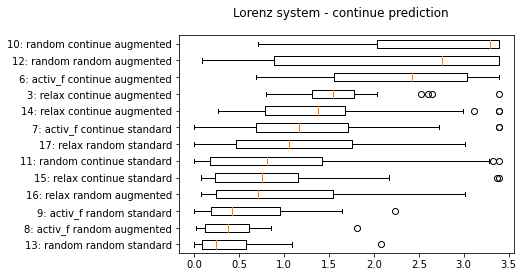

In [20]:
boxplots(results_split['lorenz'], 'continue')
plt.suptitle('Lorenz system - continue prediction')
plt.show()

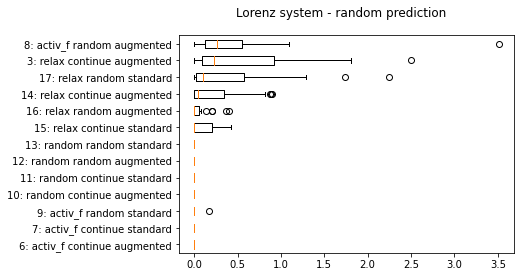

In [21]:
boxplots(results_split['lorenz'], 'random')
plt.suptitle('Lorenz system - random prediction')
plt.show()

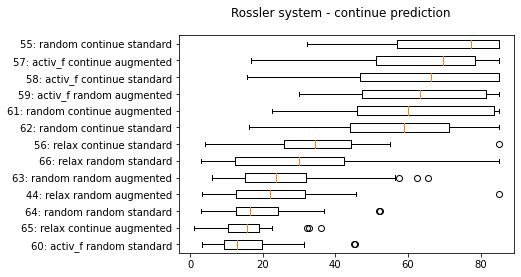

In [22]:
boxplots(results_split['rossler'], 'continue')
plt.suptitle('Rossler system - continue prediction')
plt.show()

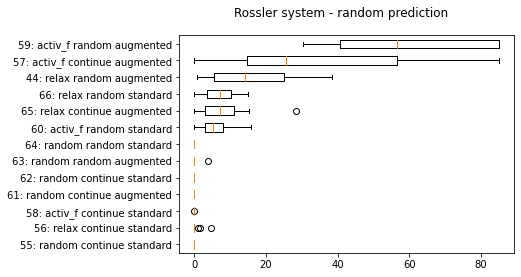

In [23]:
boxplots(results_split['rossler'], 'random')
plt.suptitle('Rossler system - random prediction')
plt.show()

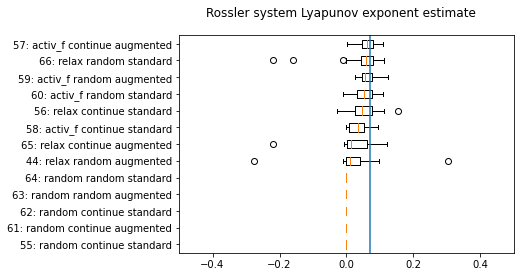

In [34]:
boxplots(results_split['rossler'], 'lyapunov',force_finite=True)
plt.suptitle('Rossler system Lyapunov exponent estimate')
plt.xlim(-0.5,0.5)
#Show the "true" value
#Based on https://arxiv.org/ftp/arxiv/papers/1412/1412.2242.pdf
plt.axvline(0.07062)
plt.show()

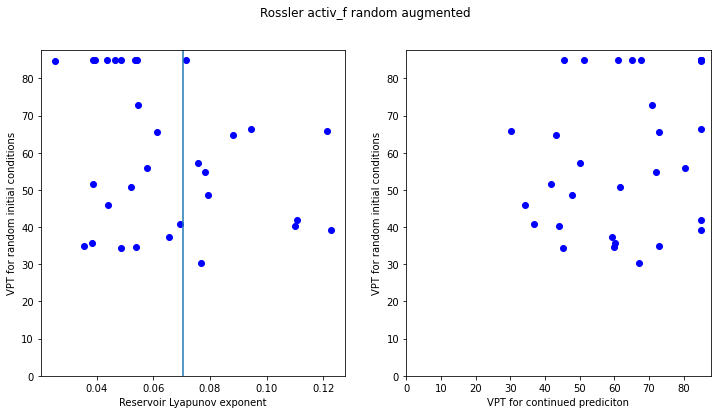

In [39]:
rossler_best = results[59]

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(rossler_best['lyapunov'], rossler_best['random'], c='b')
plt.xlabel("Reservoir Lyapunov exponent")
plt.ylabel("VPT for random initial conditions")
plt.axvline(0.07062)
plt.ylim(0,None)

plt.subplot(1,2,2)
plt.scatter(rossler_best['continue'], rossler_best['random'], c='b')
plt.xlabel("VPT for continued prediciton")
plt.ylabel("VPT for random initial conditions")
plt.axis([0,None,0,None])

plt.suptitle("Rossler activ_f random augmented")
plt.show()

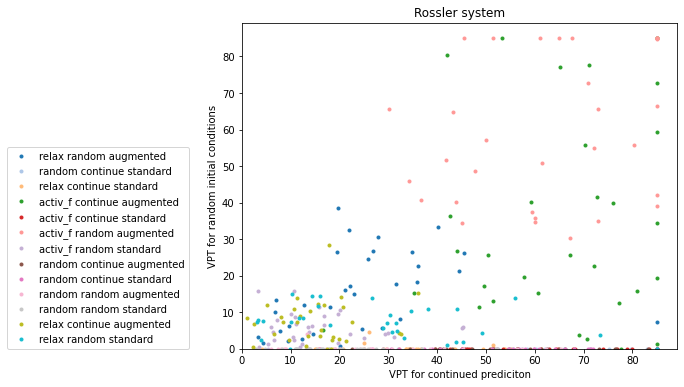

In [48]:
colors = plt.get_cmap('tab20')(np.linspace(0,1,len(results_split['rossler'])+1)[:-1])
plt.figure(figsize=(11,6))

for item, color in zip(results_split['rossler'],colors):
    plt.plot(item['continue'], item['random'], '.', color=color, label=' '.join(item['experiment'][1:]))

plt.xlabel("VPT for continued prediciton")
plt.ylabel("VPT for random initial conditions")
plt.title("Rossler system")
plt.axis([0,None,0,None])
lspace = 0.35
plt.subplots_adjust(left=lspace)
plt.legend(loc=(-lspace/(1-lspace),0))
plt.show()

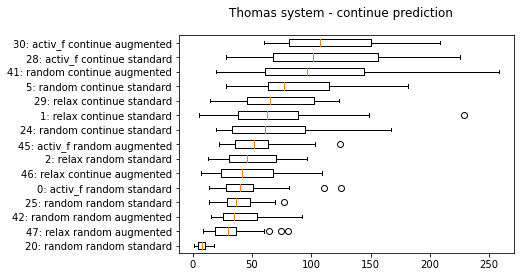

In [25]:
boxplots(results_split['thomas'], 'continue')
plt.suptitle('Thomas system - continue prediction')
plt.show()

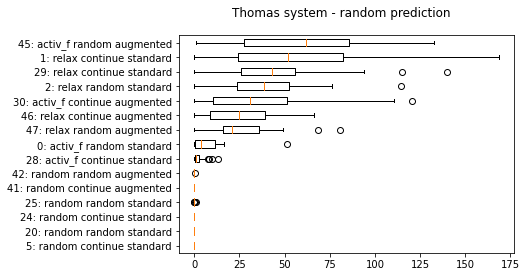

In [26]:
boxplots(results_split['thomas'], 'random')
plt.suptitle('Thomas system - random prediction')
plt.show()

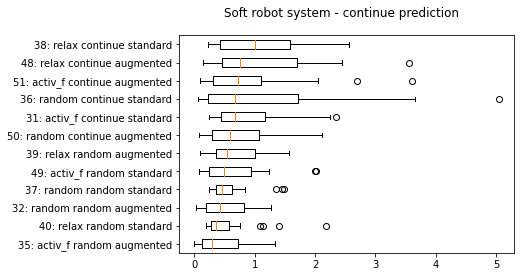

In [27]:
boxplots(results_split['softrobot'], 'continue')
plt.suptitle('Soft robot system - continue prediction')
plt.show()

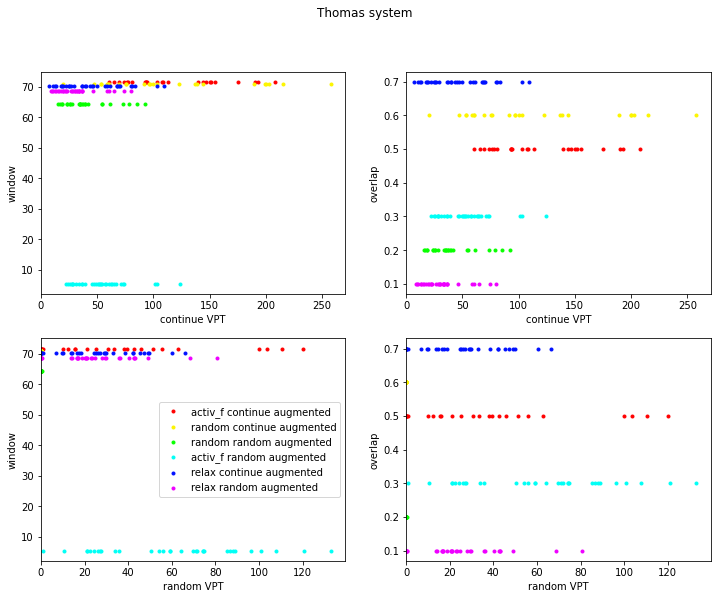

In [24]:
plt.figure(figsize=(12,9))
aug_results = [item for item in results_split['thomas'] if item['experiment'][3]=='augmented']
colors = plt.get_cmap('hsv')(np.linspace(0,1,len(aug_results)+1)[:-1])

which_exp = ['continue', 'random']
which_param = ['window','overlap']

for plt_num, (exp, param) in enumerate(product(which_exp, which_param)):
    plt.subplot(2,2,plt_num+1)
    for item, color in zip(aug_results,colors):
        l = len(item[exp])
        plt.plot(item[exp], [item['opt_parameters'][param]]*l, '.', color=color, label=' '.join(item['experiment'][1:]))
    plt.xlabel(f"{exp} VPT")
    plt.ylabel(param)
    plt.axis([0,None,None,None])
    if plt_num == 2:
        plt.legend()
    
plt.suptitle("Thomas system")
plt.show()

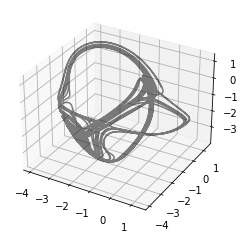

In [45]:
t,U=rc.orbit('thomas',duration=700,dt=0.1,trim=True)
rc.plot3d(U,'k');

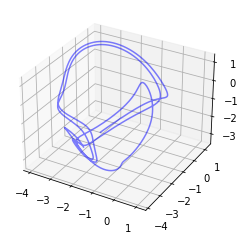

In [104]:
t,U=rc.orbit('thomas',duration=70,dt=0.1,trim=True)
rc.plot3d(U,'b');

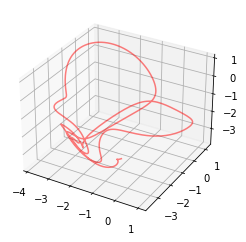

'r'

In [ ]:
plt.figure(figsize=(12,9))
aug_results = [item for item in results_split['thomas'] if item['experiment'][3]=='augmented']
colors = plt.get_cmap('hsv')(np.linspace(0,1,len(aug_results)+1)[:-1])

which_exp = ['continue', 'random']
which_param = ['window','overlap']

for plt_num, (exp, param) in enumerate(product(which_exp, which_param)):
    plt.subplot(2,2,plt_num+1)
    for item, color in zip(aug_results,colors):
        l = len(item[exp])
        plt.plot(item[exp], [item['opt_parameters'][param]]*l, '.', color=color, label=' '.join(item['experiment'][1:]))
    plt.xlabel(f"{exp} VPT")
    plt.ylabel(param)
    plt.axis([0,None,None,None])
    if plt_num == 2:
        plt.legend()
    
plt.suptitle("Rossler system")
plt.show()

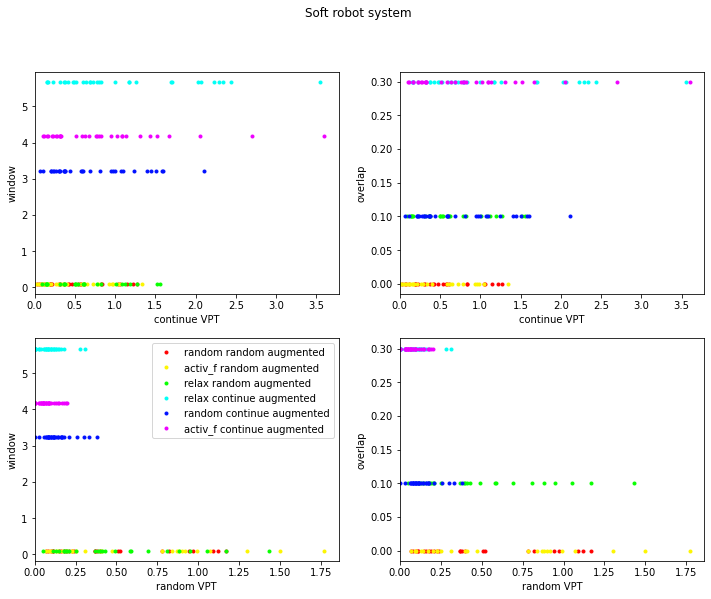

In [23]:
plt.figure(figsize=(12,9))
aug_results = [item for item in results_split['softrobot'] if item['experiment'][3]=='augmented']
colors = plt.get_cmap('hsv')(np.linspace(0,1,len(aug_results)+1)[:-1])

which_exp = ['continue', 'random']
which_param = ['window','overlap']

for plt_num, (exp, param) in enumerate(product(which_exp, which_param)):
    plt.subplot(2,2,plt_num+1)
    for item, color in zip(aug_results,colors):
        l = len(item[exp])
        plt.plot(item[exp], [item['opt_parameters'][param]]*l, '.', color=color, label=' '.join(item['experiment'][1:]))
    plt.xlabel(f"{exp} VPT")
    plt.ylabel(param)
    plt.axis([0,None,None,None])
    if plt_num == 2:
        plt.legend()
    
plt.suptitle("Soft robot system")
plt.show()

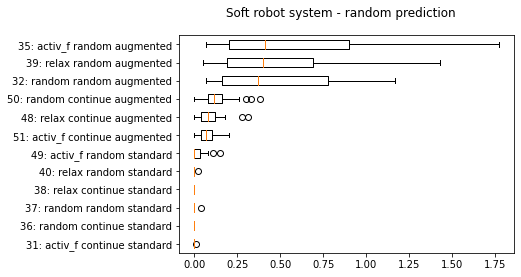

In [28]:
boxplots(results_split['softrobot'], 'random')
plt.suptitle('Soft robot system - random prediction')
plt.show()

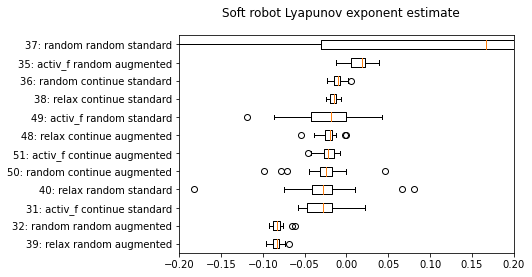

In [29]:
boxplots(results_split['softrobot'], 'lyapunov')
plt.suptitle('Soft robot Lyapunov exponent estimate')
plt.xlim(-0.2,0.2)
plt.show()

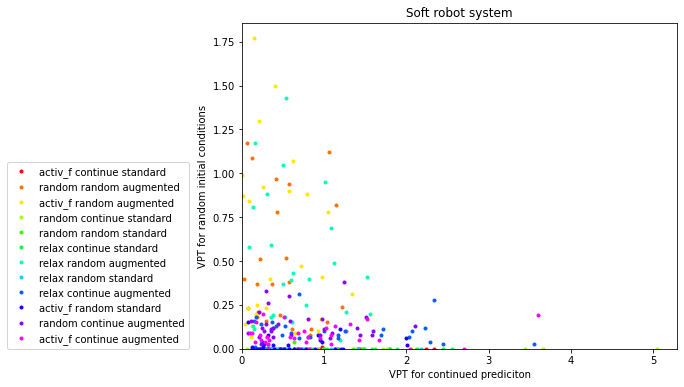

In [49]:
colors = plt.get_cmap('hsv')(np.linspace(0,1,len(results_split['rossler'])+1)[:-1])
plt.figure(figsize=(11,6))

for item, color in zip(results_split['softrobot'],colors):
    plt.plot(item['continue'], item['random'], '.', color=color, label=' '.join(item['experiment'][1:]))

plt.xlabel("VPT for continued prediciton")
plt.ylabel("VPT for random initial conditions")
plt.title("Soft robot system")
plt.axis([0,None,0,None])
lspace = 0.35
plt.subplots_adjust(left=lspace)
plt.legend(loc=(-lspace/(1-lspace),0))
plt.show()